## Data Preprocessing

In [5]:
import os
import subprocess

import joblib
import zipfile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler

In [2]:
def impute_df(df, bg_cols, insulin_cols, carbs_cols, hr_cols, steps_cols, cals_cols):
    df = df.copy()
    
    
    # Blood Glucose & Heart Rate: Linear Interpolation & Mean
    # Apply linear interpolation row-wise for bg_cols, then replace any remaining NaNs with the row mean.
    df[bg_cols] = df[bg_cols].apply(
        lambda row: row.interpolate(method='linear', limit_direction='both'), axis=1)
    df[bg_cols] = df[bg_cols].fillna(df[bg_cols].mean(axis=1))

    # Similarly, apply linear interpolation row-wise for hr_cols and fill remaining NaNs with the row mean.
    df[hr_cols] = df[hr_cols].apply(
        lambda row: row.interpolate(method='linear', limit_direction='both'), axis=1)
    df[hr_cols] = df[hr_cols].fillna(df[hr_cols].mean(axis=1))
    
    
    # Insulin & Carbs: Fill NaN w/ 0
    # For insulin_cols and carbs_cols, fill missing values with 0.
    df[insulin_cols + carbs_cols] = df[insulin_cols + carbs_cols].fillna(0)
    
    
    # Steps & Calories: Fill NaN w/ 0
    # For steps_cols and cals_cols, fill missing values with 0.
    df[steps_cols + cals_cols] = df[steps_cols + cals_cols].fillna(0)
    
    
    # Residual: Forward Fill
    # For any leftover missing values, use forward fill then backward fill as a last resort.
    df = df.fillna(method='ffill').fillna(method='bfill')
    
    return df

In [3]:
def augment_df(df):
    df = df.copy()
    
    # Define a noise factor to scale the noise to 1% of the feature's standard deviation
    noise_factor = 0.01
    
    # Define columns that should not be augmented (identifiers and target)
    exclude_cols = ['id', 'p_num', 'time', 'bg+1:00']
    
    # Get all numeric columns and exclude the ones specified above
    numeric_aug_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_aug_cols = [col for col in numeric_aug_cols if col not in exclude_cols]
    
    # Create a copy for augmented data
    df_aug = df.copy()
    
    # Add Gaussian noise to each numeric column for augmentation
    for col in numeric_aug_cols:
        std_val = df[col].std()  # Get standard deviation for scaling the noise
        df_aug[col] += np.random.normal(0, noise_factor * std_val, size=len(df))
    
    # Concatenate the original and augmented data, effectively doubling the dataset size
    return pd.concat([df, df_aug], ignore_index=True)

In [4]:
def select_df(df, bg_cols, insulin_cols, carbs_cols, hr_cols, steps_cols, cals_cols):
    df = df.copy()
    
    # For each sensor type, select only the last 24 time-steps.
    latest_bg_cols     = bg_cols[-24:]
    latest_insulin_cols = insulin_cols[-24:]
    latest_carbs_cols   = carbs_cols[-24:]
    latest_hr_cols      = hr_cols[-24:]
    latest_steps_cols   = steps_cols[-24:]
    latest_cals_cols    = cals_cols[-24:]
    
    # Combine the selected columns for time-series data
    latest_ts_cols = (
        latest_bg_cols +
        latest_insulin_cols +
        latest_carbs_cols +
        latest_hr_cols +
        latest_steps_cols +
        latest_cals_cols
    )

    # Include the 'id' column and if available, the target column 'bg+1:00'
    selected_cols = ["id"] + latest_ts_cols
    if "bg+1:00" in df.columns:
        selected_cols += ["bg+1:00"]
    
    return df[selected_cols]

In [5]:
def scale_df(df):
    # Create a copy of the dataframe
    df = df.copy()
    
    target_col = 'bg+1:00'
    # Identify all numeric columns except the target
    numeric_columns = [col for col in df.select_dtypes(include=[np.number]).columns if col != target_col]
    
    # Scale features using StandardScaler
    feature_scaler = StandardScaler()
    df[numeric_columns] = feature_scaler.fit_transform(df[numeric_columns])

    # Scale target column separately
    target_scaler = StandardScaler()
    if target_col in df.columns:
        df[[target_col]] = target_scaler.fit_transform(df[[target_col]])
    
    return df, feature_scaler, target_scaler

In [6]:
def preprocess_df(df):
    
    df = df.copy()
    
    # Identify columns for each type of feature using their prefixes
    bg_cols      = [col for col in df.columns if col.startswith("bg-")]
    insulin_cols = [col for col in df.columns if col.startswith("insulin-")]
    carbs_cols   = [col for col in df.columns if col.startswith("carbs-")]
    hr_cols      = [col for col in df.columns if col.startswith("hr-")]
    steps_cols   = [col for col in df.columns if col.startswith("steps-")]
    cals_cols    = [col for col in df.columns if col.startswith("cals-")]
    # Identify activity columns which are dropped from further analysis
    activity_cols= [col for col in df.columns if col.startswith("activity-")]

    df.drop(columns=activity_cols, inplace=True) # Remove activity features as they are not needed
    

    
    # ================================
    # Data Imputation
    # ================================
    
    # Impute missing values using the impute_df function
    df_imputed = impute_df(df, bg_cols, insulin_cols, carbs_cols, hr_cols, steps_cols, cals_cols)
    
    print("NaN Values (Data Imputation):")
    print(df_imputed.isna().any().any())
    print("\n")
    
    
    
    # ================================
    # Data Augmentation
    # ================================
    
    # Apply augmentation if the target column is available (i.e., training data)
    if "bg+1:00" in df_imputed.columns:
        df_augmented = augment_df(df_imputed)
    else:
        df_augmented = df_imputed
    
    print("NaN Values (Data Augmentation):")
    print(df_augmented.isna().any().any())
    print("\n")
    
    
    
    # ================================
    # Data Selection
    # ================================
    
    # Select only the most recent 24 data points from each feature category
    df_selected = select_df(df_augmented, bg_cols, insulin_cols, carbs_cols, hr_cols, steps_cols, cals_cols)
    
    print("NaN Values (Data Selection):")
    print(df_selected.isna().any().any())
    print("\n")
    
    print("Columns:")
    for i in df_selected.columns:
        print(i)
    print("\n")
    
    
    
    # ================================
    # Data Scaling
    # ================================
    
    # Standardize the features and the target variable
    df_scaled, feature_scaler, target_scaler = scale_df(df_selected)
    
    print("NaN Values (Data Scaling):")
    print(df_scaled.isna().any().any())
    print("\n")
    
    return df_scaled, feature_scaler, target_scaler

### Data Importing

In [7]:
# Define file paths for training and testing data
train_path = "./.data/train.csv.zip"
test_path = "./.data/test.csv"

# If train data doesn't exist, create the .data folder and download the dataset from Kaggle
if not os.path.exists(train_path):
    os.makedirs("./.data", exist_ok=True)
    print("Downloading BrisT1D ...")
    subprocess.run(["kaggle", "competitions", "download", "-c", "brist1d", "-p", "./.data"], check=True)

# Open the zipped training file and load the train.csv as a DataFrame
with zipfile.ZipFile(train_path) as z:
    with z.open("train.csv") as f:
        df_train = pd.read_csv(f)
            
# Load the test CSV directly into a DataFrame
df_test = pd.read_csv("./.data/test.csv")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_36008\3711678870.py:14: DtypeWarning: Columns (435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(f)


### Data Transformation

In [8]:
# Print raw training data for initial inspection
print(df_train)

               id p_num      time  bg-5:55  bg-5:50  bg-5:45  bg-5:40  \
0           p01_0   p01  06:10:00      NaN      NaN      9.6      NaN   
1           p01_1   p01  06:25:00      NaN      NaN      9.7      NaN   
2           p01_2   p01  06:40:00      NaN      NaN      9.2      NaN   
3           p01_3   p01  06:55:00      NaN      NaN      8.7      NaN   
4           p01_4   p01  07:10:00      NaN      NaN      8.4      NaN   
...           ...   ...       ...      ...      ...      ...      ...   
177019  p12_25294   p12  23:35:00      8.8      9.1      9.2      9.4   
177020  p12_25295   p12  23:40:00      9.1      9.2      9.4      9.8   
177021  p12_25296   p12  23:45:00      9.2      9.4      9.8     10.2   
177022  p12_25297   p12  23:50:00      9.4      9.8     10.2     10.4   
177023  p12_25298   p12  23:55:00      9.8     10.2     10.4     10.3   

        bg-5:35  bg-5:30  bg-5:25  ...  activity-0:40  activity-0:35  \
0           NaN      9.7      NaN  ...            N

In [9]:
# Preprocess the training data using the defined pipeline
df_train_preprocessed, df_train_preprocessed_feature_scaler, df_train_preprocessed_target_scaler = preprocess_df(df_train)

NaN Values (Data Imputation):
False


NaN Values (Data Augmentation):
False


NaN Values (Data Selection):
False


Columns:
id
bg-1:55
bg-1:50
bg-1:45
bg-1:40
bg-1:35
bg-1:30
bg-1:25
bg-1:20
bg-1:15
bg-1:10
bg-1:05
bg-1:00
bg-0:55
bg-0:50
bg-0:45
bg-0:40
bg-0:35
bg-0:30
bg-0:25
bg-0:20
bg-0:15
bg-0:10
bg-0:05
bg-0:00
insulin-1:55
insulin-1:50
insulin-1:45
insulin-1:40
insulin-1:35
insulin-1:30
insulin-1:25
insulin-1:20
insulin-1:15
insulin-1:10
insulin-1:05
insulin-1:00
insulin-0:55
insulin-0:50
insulin-0:45
insulin-0:40
insulin-0:35
insulin-0:30
insulin-0:25
insulin-0:20
insulin-0:15
insulin-0:10
insulin-0:05
insulin-0:00
carbs-1:55
carbs-1:50
carbs-1:45
carbs-1:40
carbs-1:35
carbs-1:30
carbs-1:25
carbs-1:20
carbs-1:15
carbs-1:10
carbs-1:05
carbs-1:00
carbs-0:55
carbs-0:50
carbs-0:45
carbs-0:40
carbs-0:35
carbs-0:30
carbs-0:25
carbs-0:20
carbs-0:15
carbs-0:10
carbs-0:05
carbs-0:00
hr-1:55
hr-1:50
hr-1:45
hr-1:40
hr-1:35
hr-1:30
hr-1:25
hr-1:20
hr-1:15
hr-1:10
hr-1:05
hr-1:00
hr-0:55
h

In [10]:
# Print the preprocessed training data to verify transformations
print(df_train_preprocessed)

               id   bg-1:55   bg-1:50   bg-1:45   bg-1:40   bg-1:35   bg-1:30  \
0           p01_0  3.094945  3.205369  3.313714  3.339652  3.360971  3.379788   
1           p01_1  3.340175  3.361377  3.380513  3.339652  3.294115  3.246211   
2           p01_2  3.340175  3.294517  3.246914  3.172466  3.093546  3.012452   
3           p01_3  3.172973  3.093934  3.013116  3.038718  3.060118  3.079240   
4           p01_4  3.039211  3.060504  3.079915  3.061009  3.037832  3.012452   
...           ...       ...       ...       ...       ...       ...       ...   
354043  p12_25294 -0.166088 -0.162144 -0.201082 -0.190677 -0.274624 -0.410811   
354044  p12_25295 -0.157866 -0.194575 -0.202508 -0.298811 -0.387798 -0.454655   
354045  p12_25296 -0.195047 -0.179183 -0.294168 -0.399377 -0.454584 -0.519700   
354046  p12_25297 -0.198411 -0.274534 -0.403222 -0.467770 -0.546534 -0.615630   
354047  p12_25298 -0.295760 -0.384807 -0.462989 -0.523887 -0.617679 -0.707057   

         bg-1:25   bg-1:20 

In [11]:
# Print raw testing data for inspection
print(df_test)

            id p_num      time  bg-5:55  bg-5:50  bg-5:45  bg-5:40  bg-5:35  \
0     p01_8459   p01  06:45:00      NaN      9.2      NaN      NaN     10.2   
1     p01_8460   p01  11:25:00      NaN      NaN      9.9      NaN      NaN   
2     p01_8461   p01  14:45:00      NaN      5.5      NaN      NaN      5.5   
3     p01_8462   p01  04:30:00      NaN      3.4      NaN      NaN      3.9   
4     p01_8463   p01  04:20:00      NaN      NaN      8.3      NaN      NaN   
...        ...   ...       ...      ...      ...      ...      ...      ...   
3639   p24_256   p24  06:40:00      7.3      7.3      7.1      6.7      6.8   
3640   p24_257   p24  12:30:00      6.0      6.2      6.2      6.2      5.8   
3641   p24_258   p24  03:45:00     12.4     12.5     12.7     13.1     13.2   
3642   p24_259   p24  06:10:00      8.3      8.3      8.2      8.2      7.8   
3643   p24_260   p24  03:10:00      9.9     10.1     10.0      9.9     10.0   

      bg-5:30  bg-5:25  ...  activity-0:45  activit

In [12]:
# Preprocess the testing data; note that augmentation is skipped if target is absent
df_test_preprocessed, df_test_preprocessed_feature_scaler, df_test_preprocessed_target_scaler = preprocess_df(df_test)

NaN Values (Data Imputation):
False


NaN Values (Data Augmentation):
False


NaN Values (Data Selection):
False


Columns:
id
bg-1:55
bg-1:50
bg-1:45
bg-1:40
bg-1:35
bg-1:30
bg-1:25
bg-1:20
bg-1:15
bg-1:10
bg-1:05
bg-1:00
bg-0:55
bg-0:50
bg-0:45
bg-0:40
bg-0:35
bg-0:30
bg-0:25
bg-0:20
bg-0:15
bg-0:10
bg-0:05
bg-0:00
insulin-1:55
insulin-1:50
insulin-1:45
insulin-1:40
insulin-1:35
insulin-1:30
insulin-1:25
insulin-1:20
insulin-1:15
insulin-1:10
insulin-1:05
insulin-1:00
insulin-0:55
insulin-0:50
insulin-0:45
insulin-0:40
insulin-0:35
insulin-0:30
insulin-0:25
insulin-0:20
insulin-0:15
insulin-0:10
insulin-0:05
insulin-0:00
carbs-1:55
carbs-1:50
carbs-1:45
carbs-1:40
carbs-1:35
carbs-1:30
carbs-1:25
carbs-1:20
carbs-1:15
carbs-1:10
carbs-1:05
carbs-1:00
carbs-0:55
carbs-0:50
carbs-0:45
carbs-0:40
carbs-0:35
carbs-0:30
carbs-0:25
carbs-0:20
carbs-0:15
carbs-0:10
carbs-0:05
carbs-0:00
hr-1:55
hr-1:50
hr-1:45
hr-1:40
hr-1:35
hr-1:30
hr-1:25
hr-1:20
hr-1:15
hr-1:10
hr-1:05
hr-1:00
hr-0:55
h

In [13]:
# Print the preprocessed testing data to verify transformations
print(df_test_preprocessed)

            id   bg-1:55   bg-1:50   bg-1:45   bg-1:40   bg-1:35   bg-1:30  \
0     p01_8459  1.498370  1.484493  1.503679  1.531703  1.553799  1.622914   
1     p01_8460 -0.486487 -0.648439 -0.811465 -0.926369 -1.035974 -1.140981   
2     p01_8461 -1.101087 -1.091123 -1.083243 -1.078102 -1.066323 -1.050196   
3     p01_8462 -1.564556 -1.609264 -1.656996 -1.624340 -1.582254 -1.534382   
4     p01_8463 -1.443651 -1.533807 -1.626799 -1.664802 -1.693533 -1.715952   
...        ...       ...       ...       ...       ...       ...       ...   
3639   p24_256 -0.748448 -0.598134 -0.509490 -0.481286 -0.600973 -0.535748   
3640   p24_257 -0.839126 -0.598134 -0.388700 -0.329553 -0.297484 -0.354179   
3641   p24_258  0.339697  0.337539  0.305844  0.277379  0.218447  0.220792   
3642   p24_259 -0.476411 -0.477402 -0.479292 -0.450939 -0.388531 -0.354179   
3643   p24_260 -0.929805 -0.960330 -0.871860 -0.875791 -0.843764 -0.747580   

       bg-1:25   bg-1:20   bg-1:15  ...  cals-0:45  cals-0:40  

### Data Exporting

In [14]:
# Export the preprocessed training and testing data to CSV files
df_train_preprocessed.to_csv("./.data/train_aug.csv", index=False)
df_test_preprocessed.to_csv("./.data/test_aug.csv", index=False)

In [15]:
# Save the feature and target scalers for later use (e.g., during model inference)
joblib.dump(df_train_preprocessed_feature_scaler, './.data/feature_scaler_aug.pkl')
joblib.dump(df_train_preprocessed_target_scaler, './.data/target_scaler_aug.pkl')

['./.data/target_scaler_aug.pkl']

## Exploratory Data Analysis (EDA)

In [16]:
import os
import subprocess

import joblib
import zipfile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler

In [17]:
# Reload the preprocessed data and the target scaler from disk
df_train_preprocessed = pd.read_csv("./.data/train_aug.csv")
df_test_preprocessed = pd.read_csv("./.data/test_aug.csv")
target_scaler = joblib.load('./.data/target_scaler_aug.pkl')

In [18]:
# Inverse transform the scaled target variable to restore it to its original scale for interpretability
df_train_preprocessed["bg+1:00"] = target_scaler.inverse_transform(
    df_train_preprocessed["bg+1:00"].values.reshape(-1, 1)
).ravel()

In [19]:
# Extract the participant number from the 'id' column using a regex, store it in a new column 'p_num'
df_train_preprocessed['p_num'] = df_train_preprocessed['id'].str.extract(r"(p\d{2})")

### Descriptive Analysis

In [20]:
# Select the target column for analysis
bg_1 = df_train_preprocessed["bg+1:00"]

In [21]:
# Compute global summary statistics for the target variable
global_stats = {
    "mean": bg_1.mean(),
    "median": bg_1.median(),
    "std_dev": bg_1.std(),
    "min": bg_1.min(),
    "max": bg_1.max(),
    "sum": bg_1.sum(),
    "count": bg_1.count(),
    "q1": bg_1.quantile(0.25),
    "q3": bg_1.quantile(0.75),
}

global_stats["IQR"] = global_stats["q3"] - global_stats["q1"]
global_stats["skewness"] = skew(bg_1, bias=False)
global_stats["kurtosis"] = kurtosis(bg_1, bias=False)

In [22]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 1000)

print("Global Summary:")
display(pd.DataFrame([global_stats]).style.hide(axis="index"))

pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")
pd.reset_option("display.max_colwidth")
pd.reset_option("display.width")

Global Summary:


In [23]:
# Group the data by participant and aggregate target statistics for each group
group_stats = df_train_preprocessed.groupby("p_num")["bg+1:00"].agg([
    ("mean", "mean"),
    ("median", "median"),
    ("std_dev", "std"),
    ("min", "min"),
    ("max", "max"),
    ("sum", "sum"),
    ("count", "count"),
    ("q1", lambda x: x.quantile(0.25, interpolation='nearest')),
    ("q3", lambda x: x.quantile(0.75, interpolation='nearest')),
])
group_stats["IQR"] = group_stats["q3"] - group_stats["q1"]

In [24]:
# Define a function to compute skewness and kurtosis for a given participant group
def compute_skew_kurt(group):
    return pd.Series({
        "skewness": skew(group["bg+1:00"], bias=False),
        "kurtosis": kurtosis(group["bg+1:00"], bias=False)
    })

# Apply the function to each participant group and merge with other summary statistics
skew_kurt = df_train_preprocessed.groupby("p_num").apply(compute_skew_kurt).reset_index()

In [25]:
# Merge group statistics with skewness and kurtosis, then sort by participant number
final_stats = group_stats.reset_index().merge(skew_kurt, on="p_num")
final_stats = final_stats.sort_values("p_num")

In [26]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 1000)

print("P_NUM Summary:")
display(final_stats.style.hide(axis="index"))

pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")
pd.reset_option("display.max_colwidth")
pd.reset_option("display.width")

P_NUM Summary:


### Visual Analysis

In [27]:
# Create a DataFrame with only the participant number and the target value for plotting
df_train_preprocessed_pd = df_train_preprocessed[["p_num", "bg+1:00"]]
stats_pd = final_stats

# Get a sorted list of participants to iterate over in plots
participants = sorted(df_train_preprocessed_pd["p_num"].unique())
n = len(participants)

# Set Seaborn visual style
sns.set(style="whitegrid", palette="muted")

#### Barplot: Mean of BG+1:00/P_NUM

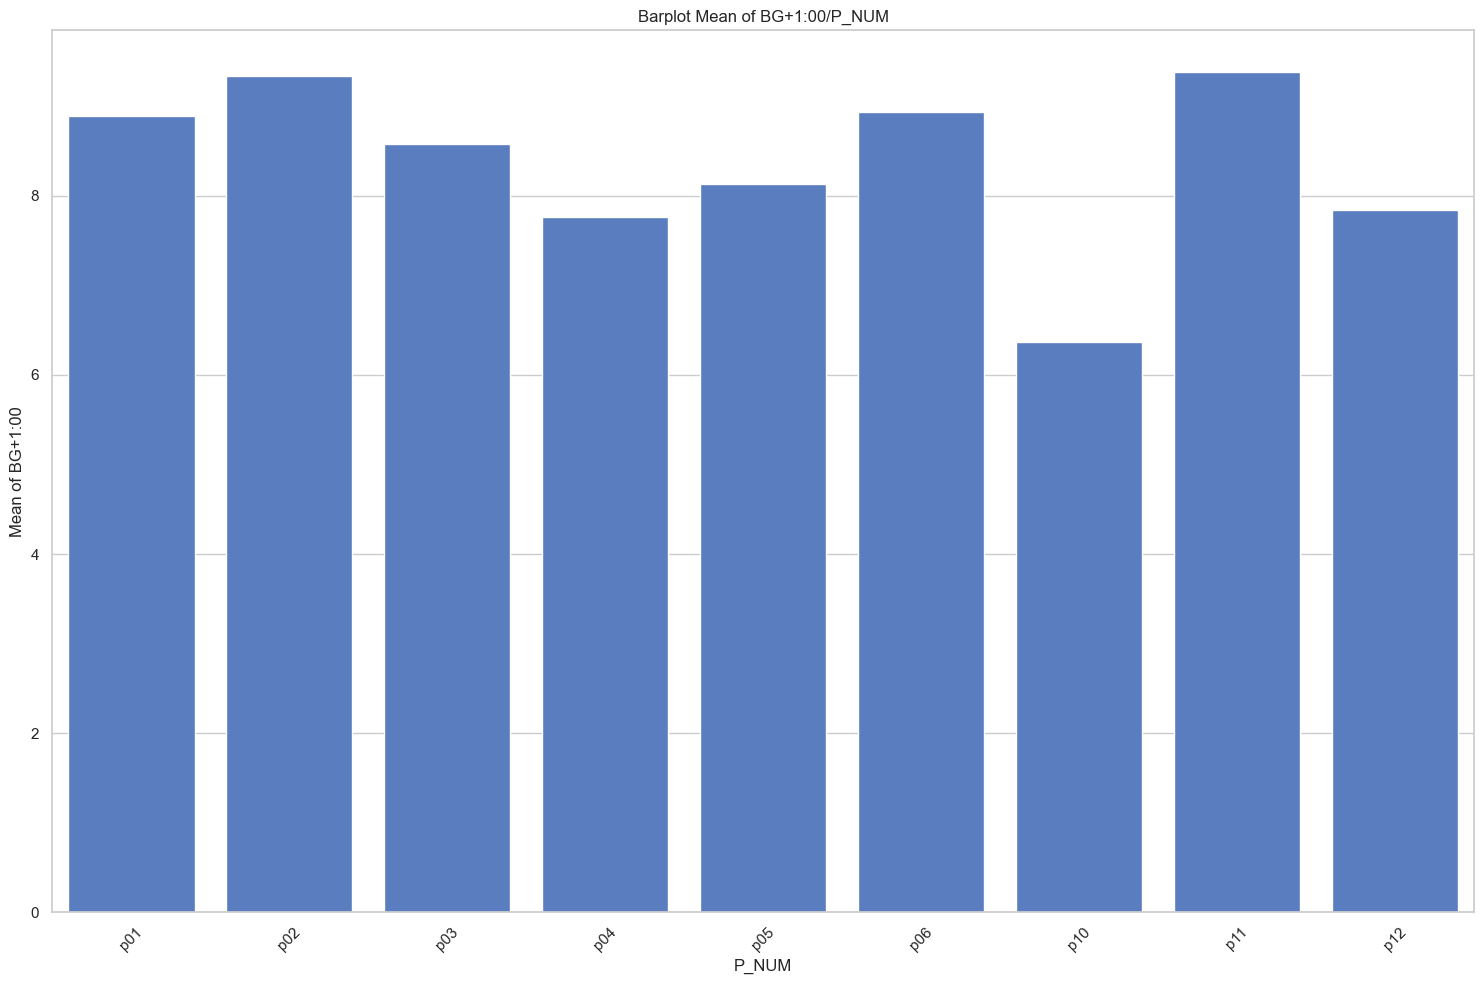

In [28]:
plt.figure(figsize=(15, 10))
sns.barplot(data=stats_pd, x="p_num", y="mean")
plt.title("Barplot Mean of BG+1:00/P_NUM")
plt.xlabel("P_NUM")
plt.ylabel("Mean of BG+1:00")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Barplot: Interquartile Range (IQR) of BG+1:00/P_NUM

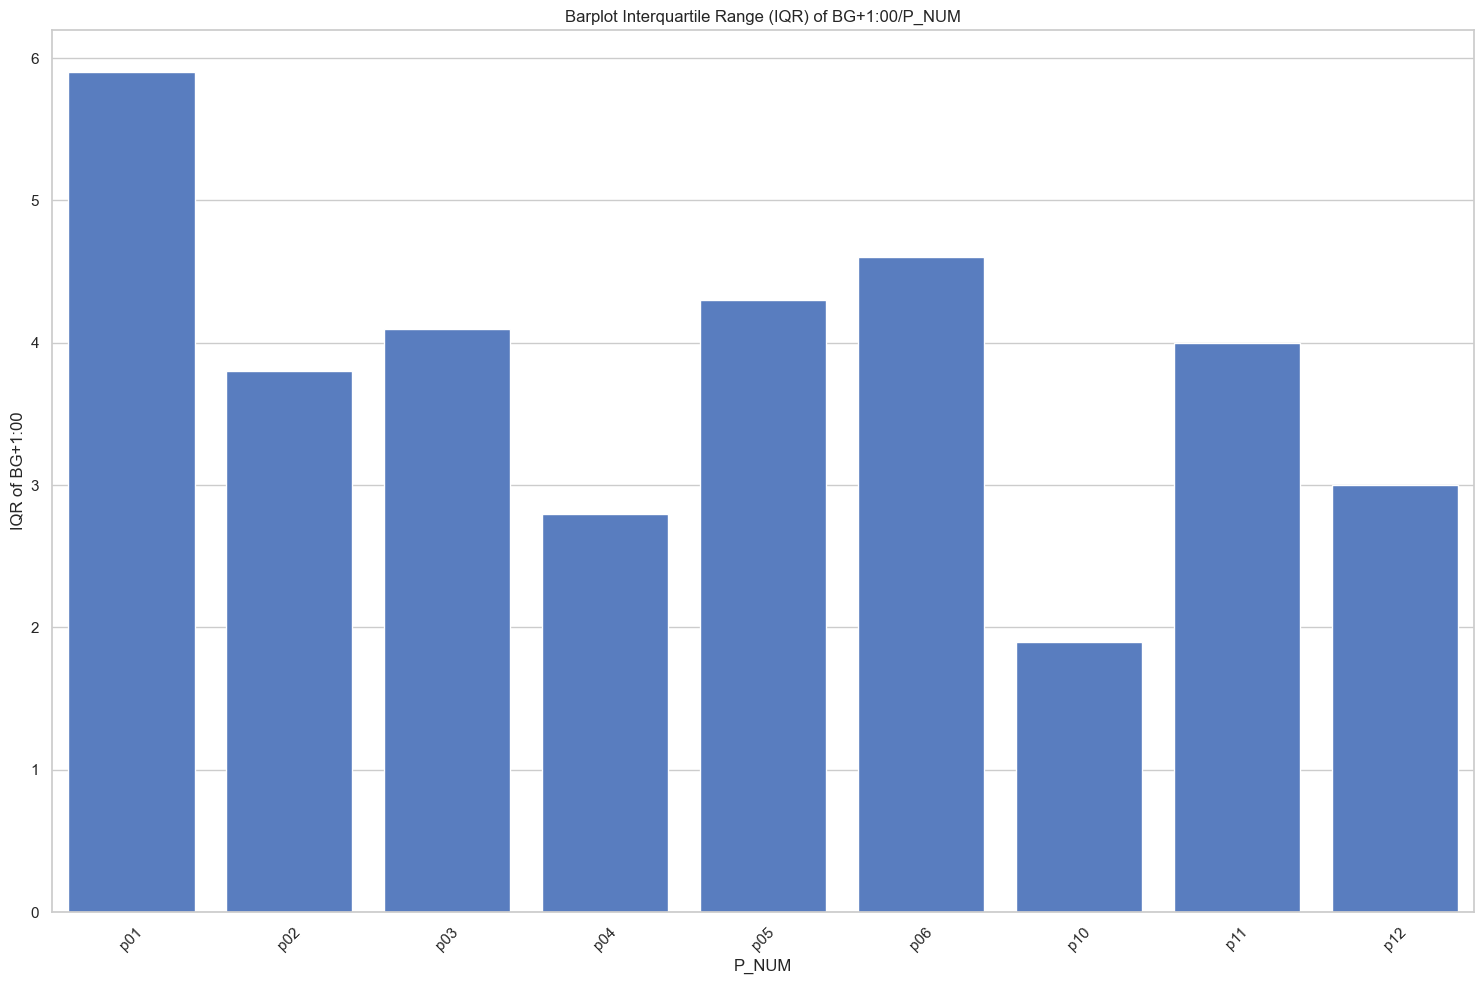

In [29]:
plt.figure(figsize=(15, 10))
sns.barplot(data=stats_pd, x="p_num", y="IQR")
plt.title("Barplot Interquartile Range (IQR) of BG+1:00/P_NUM")
plt.xlabel("P_NUM")
plt.ylabel("IQR of BG+1:00")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Barplot: Standard Deviation (SD) of BG+1:00/P_NUM

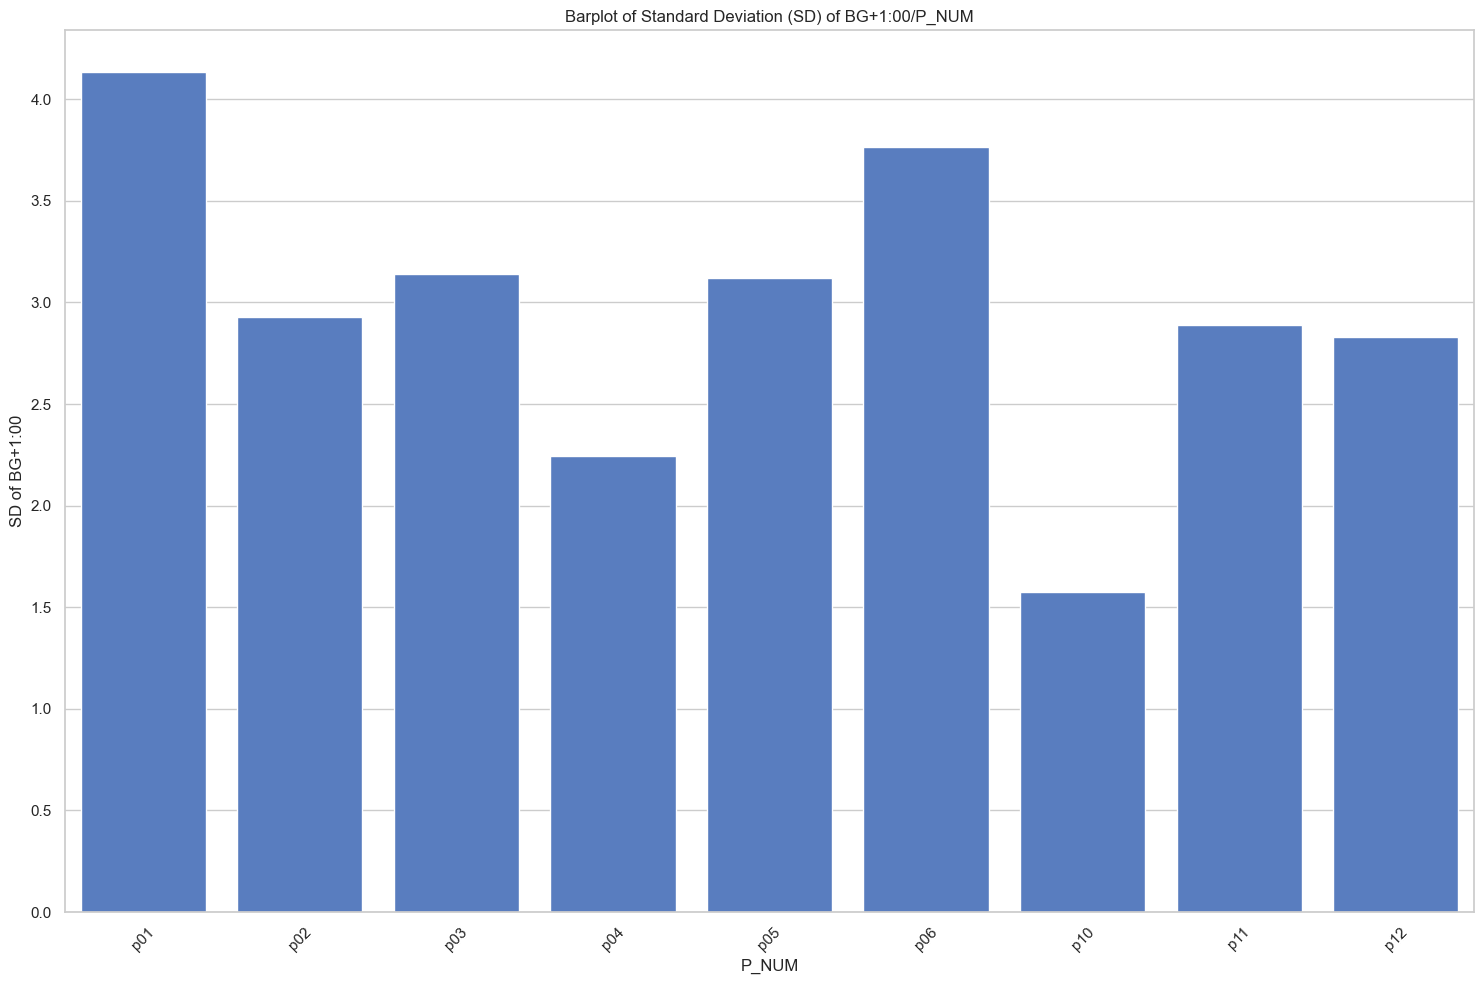

In [30]:
plt.figure(figsize=(15, 10))
sns.barplot(data=stats_pd, x="p_num", y="std_dev")
plt.title("Barplot of Standard Deviation (SD) of BG+1:00/P_NUM")
plt.xlabel("P_NUM")
plt.ylabel("SD of BG+1:00")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Scatterplot: Skewness vs. Kurtosis of BG+1:00/P_NUM

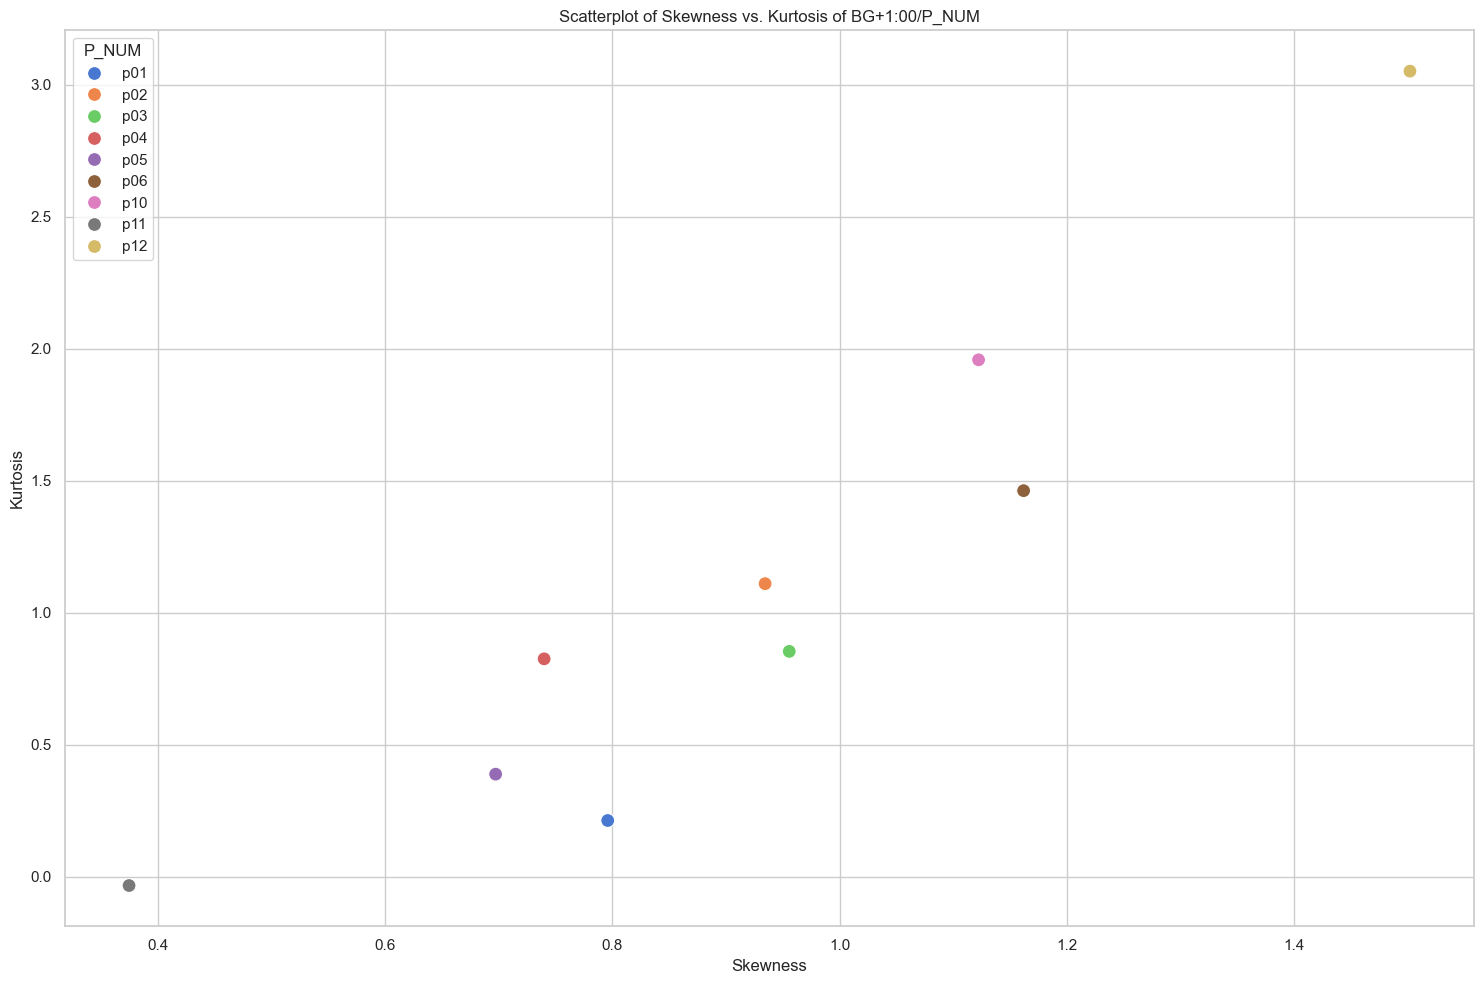

In [31]:
plt.figure(figsize=(15, 10))
sns.scatterplot(data=stats_pd, x="skewness", y="kurtosis", hue="p_num", s=100)
plt.title("Scatterplot of Skewness vs. Kurtosis of BG+1:00/P_NUM")
plt.xlabel("Skewness")
plt.ylabel("Kurtosis")
plt.legend(title="P_NUM")
plt.tight_layout()
plt.show()

#### Boxplot: BG+1:00/P_NUM

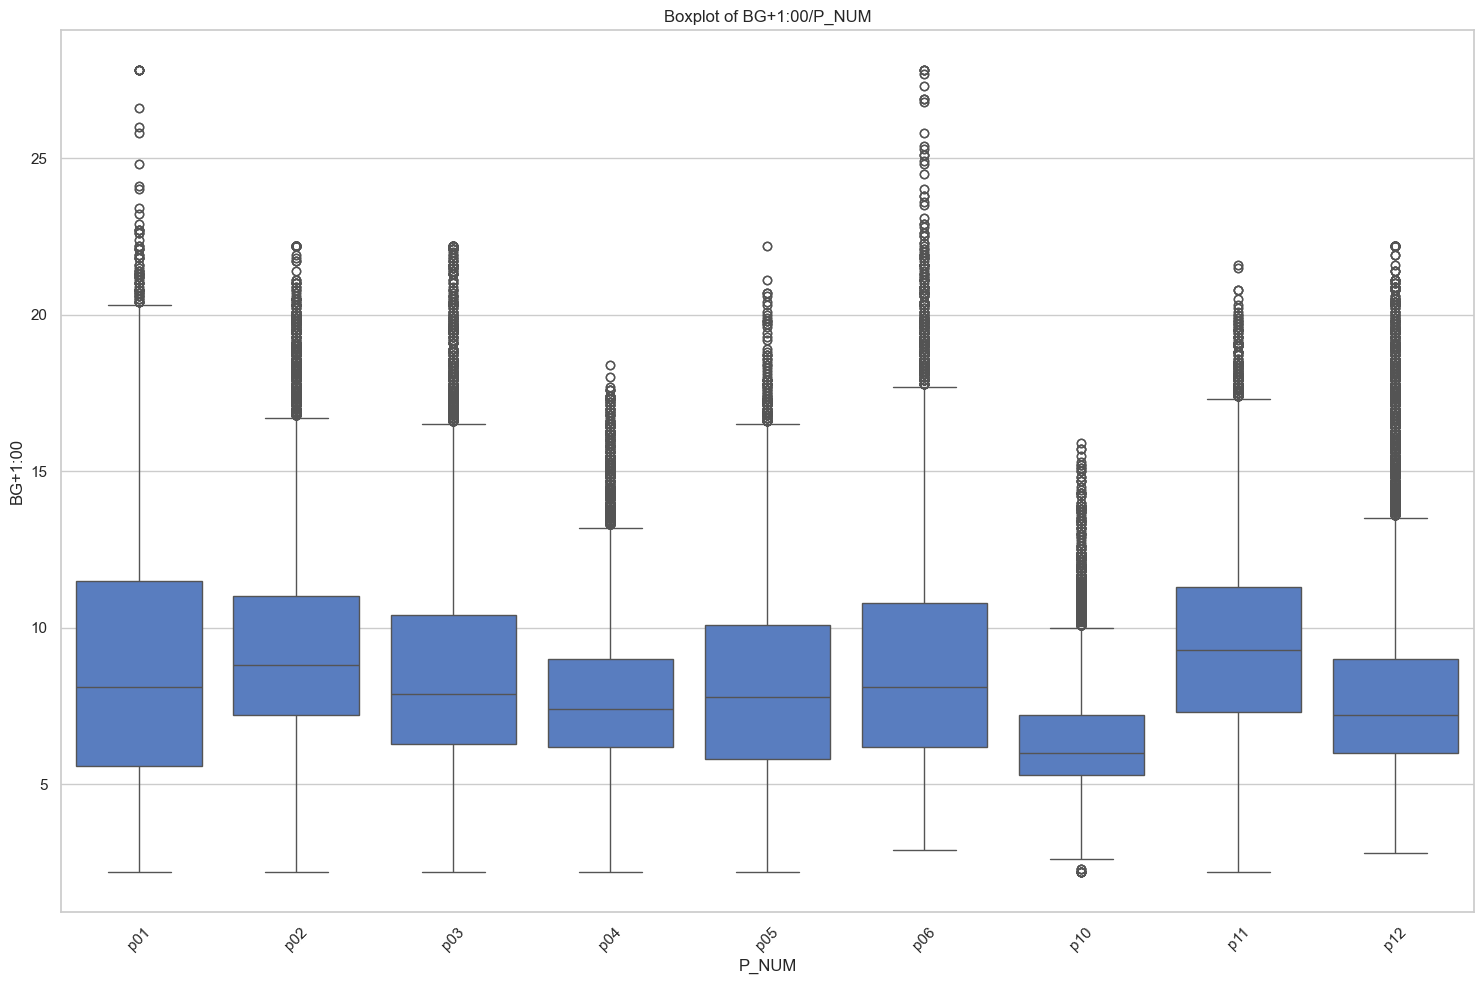

In [32]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=df_train_preprocessed_pd, x="p_num", y="bg+1:00")
plt.title("Boxplot of BG+1:00/P_NUM")
plt.ylabel("BG+1:00")
plt.xlabel("P_NUM")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Histogram: BG+1:00/P_NUM

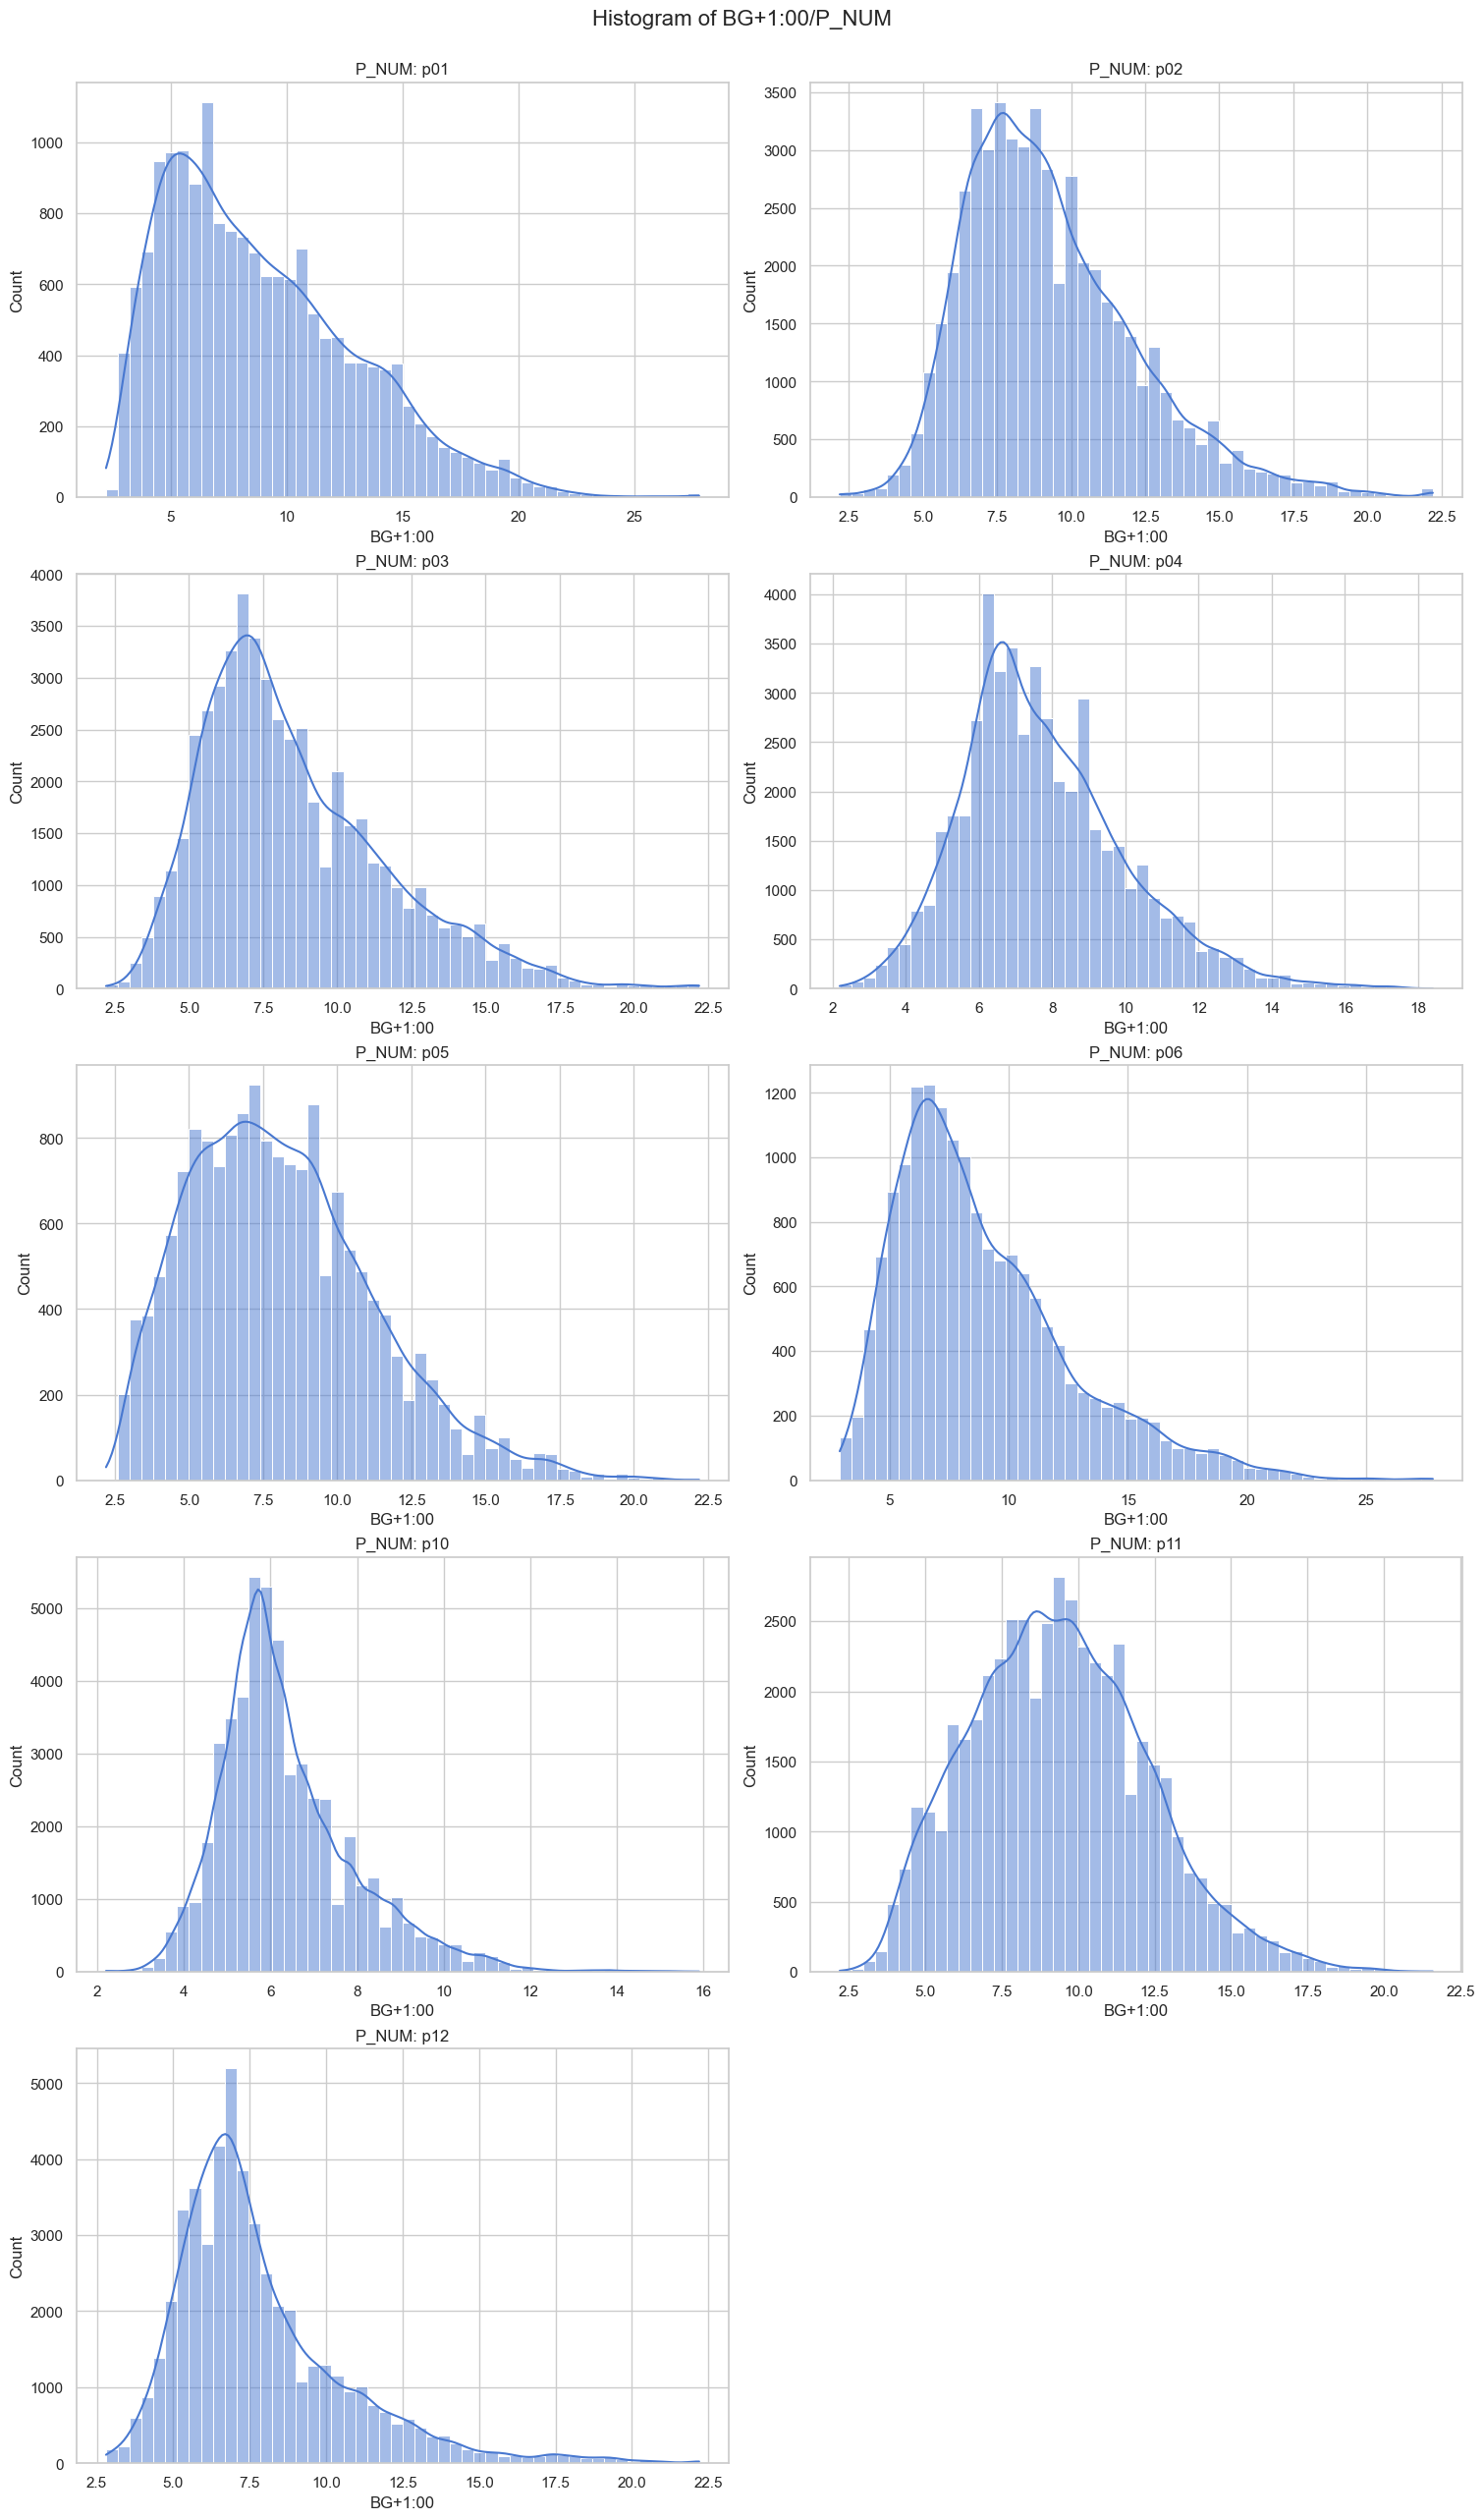

In [33]:
# Determine grid layout for subplots based on the number of participants
ncols = 2
nrows = (n + ncols - 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 5), constrained_layout=True)

axes = axes.flatten()

# Plot a histogram with KDE for each participant's target variable
for idx, pid in enumerate(participants):
    subset = df_train_preprocessed_pd[df_train_preprocessed_pd["p_num"] == pid]
    ax = axes[idx]
    sns.histplot(subset["bg+1:00"], bins=50, kde=True, ax=ax)
    ax.set_title(f"P_NUM: {pid}")
    ax.set_xlabel("BG+1:00")
    ax.set_ylabel("Count")

# Hide any unused subplots in the grid
for ax in axes[len(participants):]:
    ax.set_visible(False)

plt.suptitle("Histogram of BG+1:00/P_NUM", fontsize=16, y=1.02)
plt.show()